In [4]:
import sys
formerPath = sys.path
sys.path.append('./code/')
sys.path.append('./BS/')

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn as skl


import bootstrapping
import dataSetConstruction
import backtest
import BS
import loadData
import plotTools
import SSVI
import neuralNetwork


from Bisect import bisect
from newton import newton
from BSImplVol import bsimpvol

import importlib

Instructions for updating:
non-resource variables are not supported in the long term


# Load modules and external files

You need to import four python scripts for implied volatility calibration :
- *newton.py*
- *BSImplVol.py*
- *BS.py*
- *Bisect.py*

In [14]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
#Load python files to google colaborative environment
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

In [323]:
importlib.reload(loadData)

<module 'loadData' from './code/loadData.py'>

# Load data with google colab 

#### From excel file :

You will find in github repository six days of data.
For each day you need to load six csv files :
- *underlying.csv* for the stock value.
- *locvol.csv* for the local volatility calibrated with tree pricing and tikhonov volatility (see Crépey (2002)).
- *dividend.csv* for dividend extracted from put-call parity.
- *discount.csv* for zero-coupon curve. 
- *dataTrain.csv* for prices and/or implied volatility used in training set.
- *dataTest.csv* for prices and/or implied volatility used in testing set.

In [3]:
#Load csv files to get data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

ModuleNotFoundError: No module named 'google.colab'

In [188]:
workingFolder = "./data/09082001/"

Bootstrap discounting


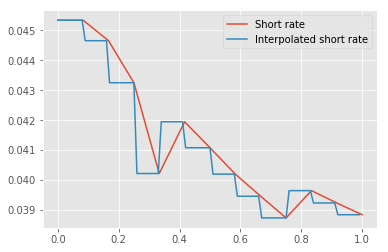

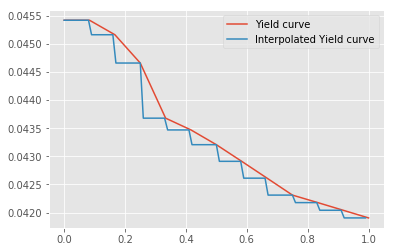

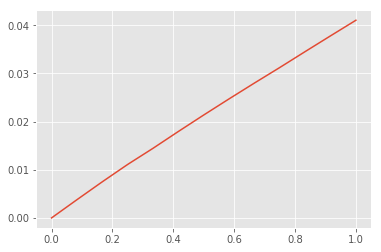

Bootstrap dividend


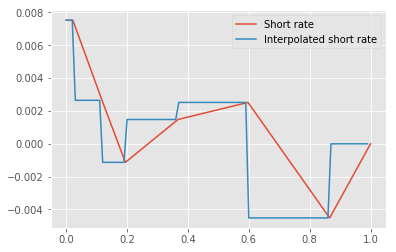

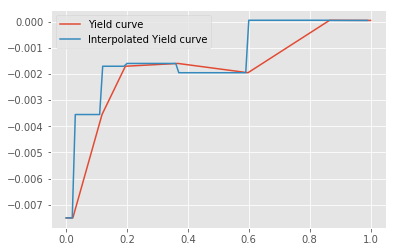

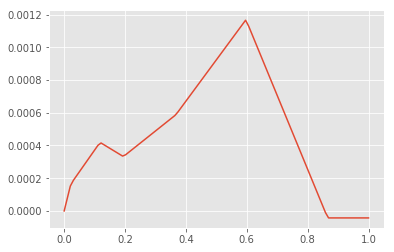

In [189]:
#Read csv files as dataFrames
trainingSet, testingSet, bootstrap, S0 = loadData.loadDataFromCSV(workingFolder,
                                                                  "9_8_2001__filterdax")

#### From Dat files

Tikhonov PDE repricing error on training set :  2.4207935408017573
Bootstrap discounting


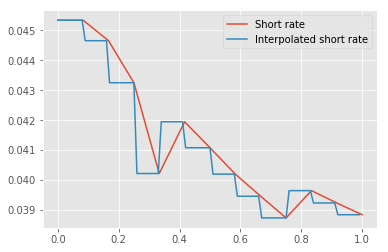

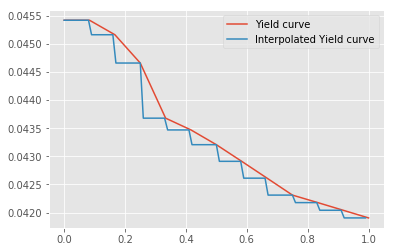

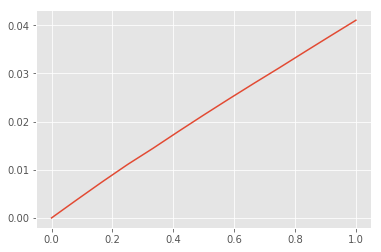

Bootstrap dividend


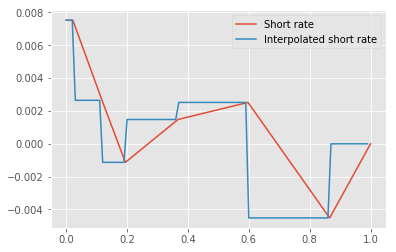

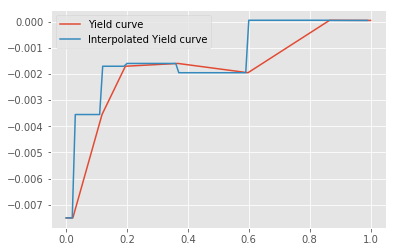

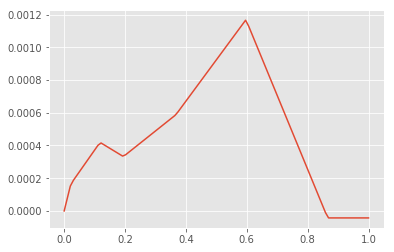

In [18]:
trainingSet, testingSet, bootstrap, S0 = loadData.loadDataFromDat(workingFolder,
                                                                  "9_8_2001__filterdax")

In [19]:
importlib.reload(loadData)

<module 'loadData' from './code/loadData.py'>

In [20]:
pd.options.mode.chained_assignment = 'raise'

#### SPX Data

We assume a piecewise constant discount short rate $r$ and a piecewise constant dividend short rate $q$.

We estimate the "zero coupon dividend" $D(T) = e^{-\int_{0}^{T} q_s ds}$ by regressing it against maturity :
$$e^{-\int_{0}^{T} q_s ds} = \frac{C(T,K) - P(T,K) + K e^{-\int_{0}^{T} r_s ds}}{S_0}$$


Then we have $\hat{q}_t = - \frac{ \log{D(\overline{T})} - \log{D(\underline{T})} }{ \overline{T} - \underline{T} }$ with $\overline{T}$ the smallest discretized maturity greater than $T$ and $\underline{T}$ the grestest discretized maturity inferior than $T$.

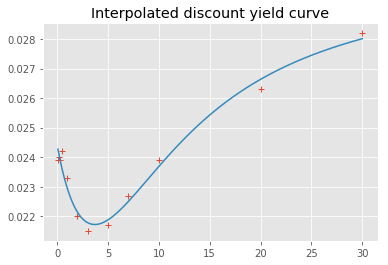

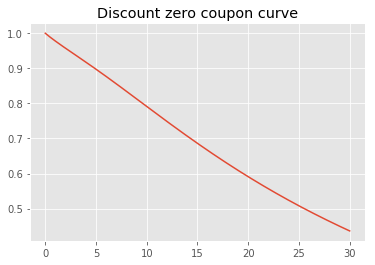

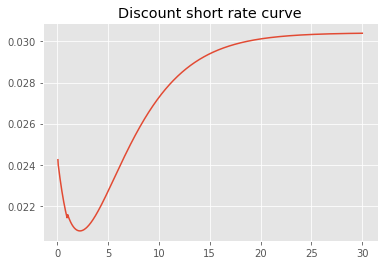

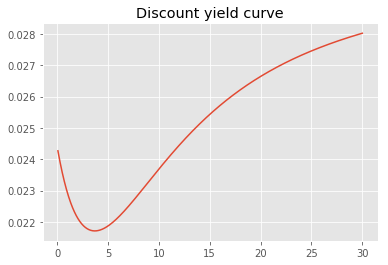

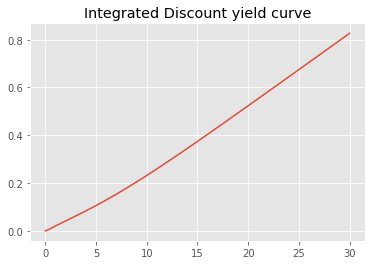

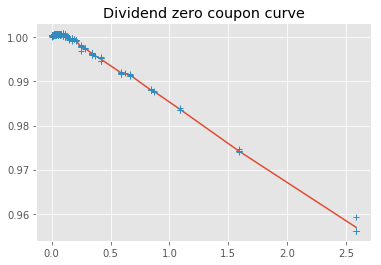

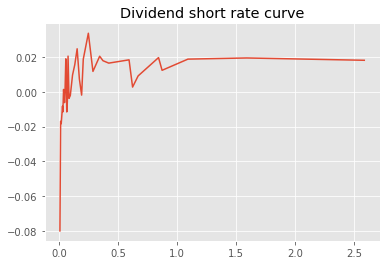

./code/bootstrapping.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / x - 1) / float(t)


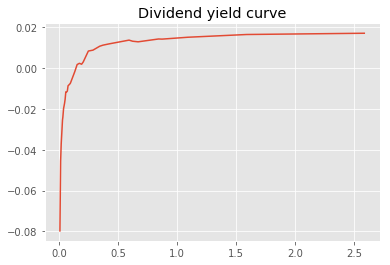

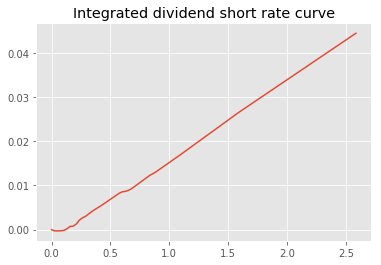

In [324]:
workingFolder = "./data/"
fileName = "Option_SPX_18_Mai_2019Feuille2.xlsm"
asOfDate = "2019-05-18"
trainingSet, testingSet, bootstrap, S0 = loadData.loadCBOTData(workingFolder, fileName, asOfDate)

In [22]:
importlib.reload(bootstrapping)

<module 'bootstrapping' from '/home/chataigner/Téléchargements/LOCVOL/bootstrapping.py'>

####  Eurostoxx data

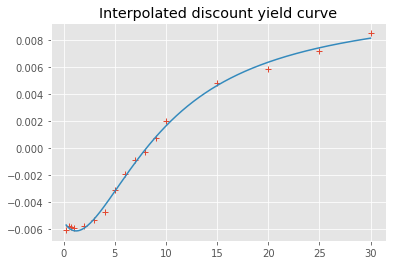

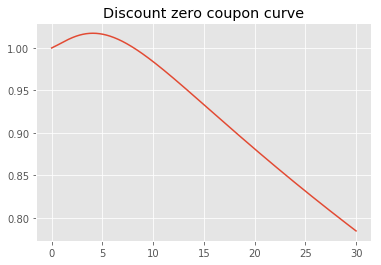

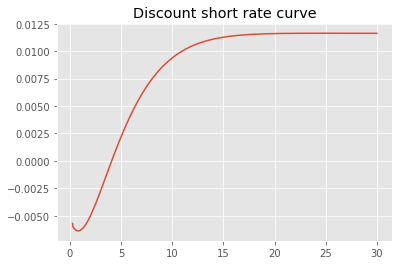

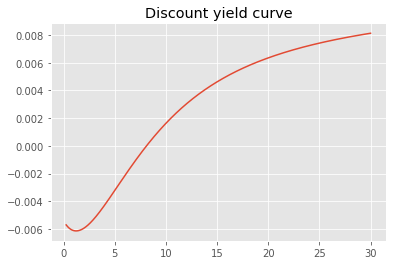

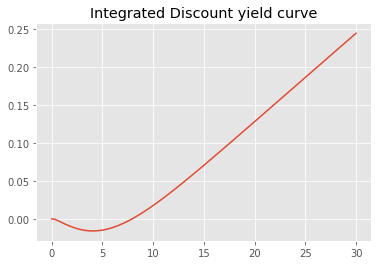

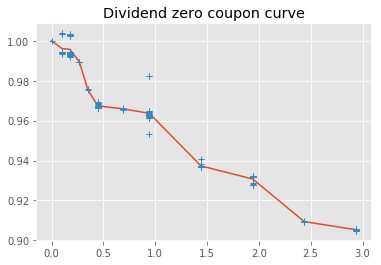

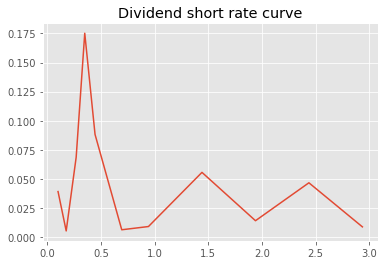

./code/bootstrapping.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / x - 1) / float(t)


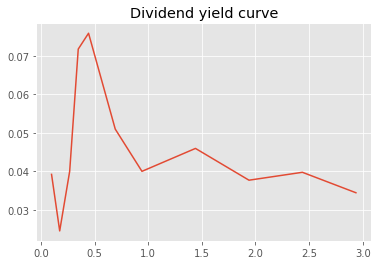

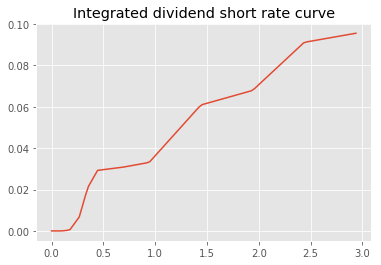

In [317]:
workingFolder = "./data/"
asOfDate = "2019-01-10"
filename = "Data_EuroStoxx50_20190110_all_for_Marc.xlsx"
trainingSet, testingSet, bootstrap, S0 = loadData.loadESXData(workingFolder, filename, asOfDate)

In [192]:
bootstrap.discountShortRate(10)

array(0.009402)

# Formatting data

### Boostsrapping Rate Curve


- For bootstrapping short rate $r$ and dividend rate $q$, we assume piecewise constant short rate for risk free rate and dividend i.e. 
$\exp{(-\int_{0}^{T} r_t d_t)} = \exp{(-\sum_{i} r_i h)}$ and $\exp{(\int_{0}^{T} q_t d_t)} = \exp{(\sum_{i} q_i h)}$.
- $\forall i \in \{0,..,N\}$ with $ t_0 = 0$ and $t_N = T$, we have that $\frac{\log{B(0,t_{i+1})} - \log{B(0,t_i)}}{h} = r_i$ with $B(0,T_i)$ the price of a bond expiring at time $t_i$. 
- For dividend, we just to substitute $B(0,T_i)$ with with spot action price plus dividend cash flow received until time $T_i$ i.e. $S_{t_0} + \sum\limits_i Div_{t_i}$.
- Then we linearly interpolate $r$ and $q$.
-  Linear interpolation is also used for integrals $\int_{0}^{T} q_t d_t$ and $\int_{0}^{T} r_t d_t$ in order to obtain discount factor or dividend factor. 

**riskFreeIntegral** corresponds to $I_T = \int_{0}^{T} r_u du$.
**riskFreeSpline**  corresponds to $r_u$ evaluated on a subgrid. Interpolated as step function from zero coupons

**divSpreadIntegral** corresponds to $I_T = \int_{0}^{T} q_u du$, can be negative.
**divSpline**  corresponds to $q_u$ evaluated on a subgrid, can be negative.

Training dataset is built on market prices observed on the dax.
Testing dataset is list of prices drawn from an excel provided by Stephane Crépey.
Prices come from the calibrated local volatility with tikhonov regularisation (see Crépey 2002 paper).
Implied volatitilities in both dataset are obtained from local volatility.

These curve satisfy together the call put parity.

Spot level is contained in underlying.csv

### Pricing black-scholes price

#### Change of variable

- In presence of dividend rate $d$ and risk free rate $r$ Dupire formula is :   $$\sigma^2(T,K) = 2 \frac{ \partial_T P(T,K) + (r-q) K \partial_K P(T,K) + qP(T,K)}{K² \partial_{K}^2 P(T,K)}$$ 
with Strike $K$, Maturity $T$, dividend rate $q$ and risk-free rate $r$, $P$ our pricing function. 
- We apply the following change of variable : $$ w(T,k) = \exp{(\int_{0}^{T} q_t dt)} P(T,K)$$ with $K = k \exp{(\int_{0}^{T} (r_t - q_t) dt)} $.

- Then Dupire equation becomes :  $\sigma^2(T,K) = 2 \frac{ \partial_T w(T,k)}{k² \partial_{k}^2 w(T,k)}$. 
- If we learn the mapping $v$ with a neural network then we should obtain quickly by adjoint differentiation $\partial_T w$ and $\partial_{k²}^2 w$ and therefore $\sigma$.


Call put parity max absolute relative error :  1.8509653739217662  ,  2875.0  ,  0.841
Call put parity mean absolute relative error :  0.07921040310463882
Call put parity is violated


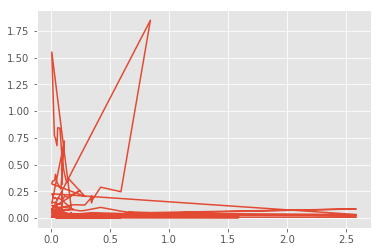

In [326]:
dataSetConstruction.checkCallPutParity(pd.concat([trainingSet, testingSet]), 
                                       S0, 
                                       bootstrap)

In [327]:
dataSet = trainingSet #Training set
dataSetTest = testingSet #Testing set
dataSet.head()

,,Price,Delta,Vega,Delta Strike,Gamma Strike,Theta,ChangedStrike,DividendFactor,Strike,Maturity,ImpliedVol,VegaRef,OptionType,logMoneyness,impliedTotalVariance
Strike,Maturity,,,,,,,,,,,,,,,
1700.0,0.246,0.80,-0.004171,17.445534,0.009788,-0.000018,15.329284,1697.643924,0.997527,1700.0,0.246,0.4147,0.062925,-1.0,-0.521416,0.042306
2200.0,0.419,671.15,0.954106,178.246247,-2.775941,0.005611,-4731.157502,2194.553900,0.994628,2200.0,0.419,0.2550,169.246997,1.0,-0.264678,0.027245
2400.0,0.419,20.55,-0.099289,323.155078,0.185544,0.000106,187.583551,2394.058800,0.994628,2400.0,0.419,0.2264,368.610408,-1.0,-0.177667,0.021477
2550.0,0.112,318.35,0.937960,117.016911,-2.546618,0.009389,-8519.282870,2547.963157,1.000111,2550.0,0.112,0.2299,139.166804,1.0,-0.115363,0.005920
2625.0,0.112,247.60,0.896813,171.829491,-2.220371,0.009018,-5780.569433,2622.903250,1.000111,2625.0,0.112,0.2101,214.406617,1.0,-0.086375,0.004944


In [328]:
dataSetTest.head()

Price     Delta        Vega  Delta Strike  Gamma Strike  \
Strike Maturity                                                             
2300.0 0.419     576.40  0.933088  240.025770     -2.520054      0.005324   
       0.419      14.30 -0.066912  240.025770      0.127354      0.000031   
2325.0 0.112     538.00  0.986832   32.392962     -3.402388      0.009696   
       0.112       1.65 -0.013168   32.392962      0.022592     -0.000039   
2350.0 0.093     512.05  0.986981   29.227795     -3.398399      0.010110   

                        Theta  ChangedStrike  DividendFactor  Strike  \
Strike Maturity                                                        
2300.0 0.419     -3788.369666    2294.306350        0.994628  2300.0   
       0.419       136.150858    2294.306350        0.994628  2300.0   
2325.0 0.112    -17409.494365    2323.142879        1.000111  2325.0   
       0.112        60.728655    2323.142879        1.000111  2325.0   
2350.0 0.093    -19293.280149    2348.768497        1.000292  2350.0   

                 Maturity  ImpliedVol     VegaRef  OptionType  logMoneyness  \
Strike Maturity                                                               
2300.0 0.419        0.419      0.2393  261.160274         1.0     -0.220227   
       0.419        0.419      0.2393  261.160274        -1.0     -0.220227   
2325.0 0.112        0.112      0.2856   15.762704         1.0     -0.207736   
       0.112        0.112      0.2856   15.762704        -1.0     -0.207736   
2350.0 0.093        0.093      0.2959   11.271760         1.0     -0.196766   

                 impliedTotalVariance  
Strike Maturity                        
2300.0 0.419                 0.023994  
       0.419                 0.023994  
2325.0 0.112                 0.009136  
       0.112                 0.009136  
2350.0 0.093                 0.008143

In [329]:
dfCurve = dataSetConstruction.savingData(bootstrap, 
                                         dataSet, 
                                         dataSetTest, 
                                         workingFolder)

Saving bootstrapping under dfCurve.csv
Saving training set under trainingDataSet.csv
Saving bootstrapping under testingDataSet.csv


In [330]:
dataSet.shape

(223, 15)

In [331]:
dataSetTest.shape

(666, 15)

In [332]:
S0

2859.53

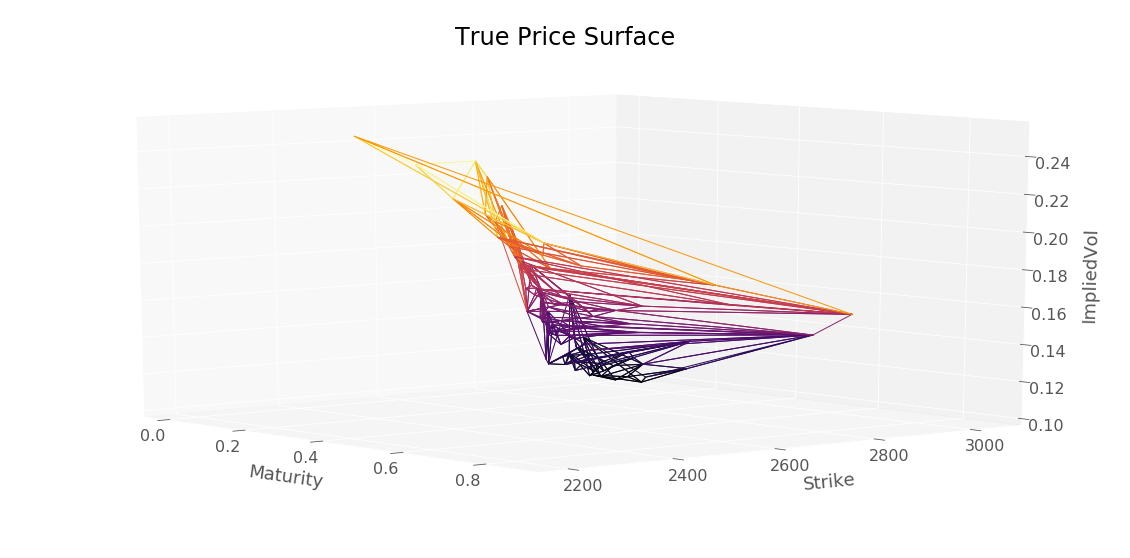

In [333]:
def getCall(df):
    return df[df["OptionType"]==1]
def getPut(df):
    return df[df["OptionType"]==-1]
    
plotTools.plotSerie(getCall(trainingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

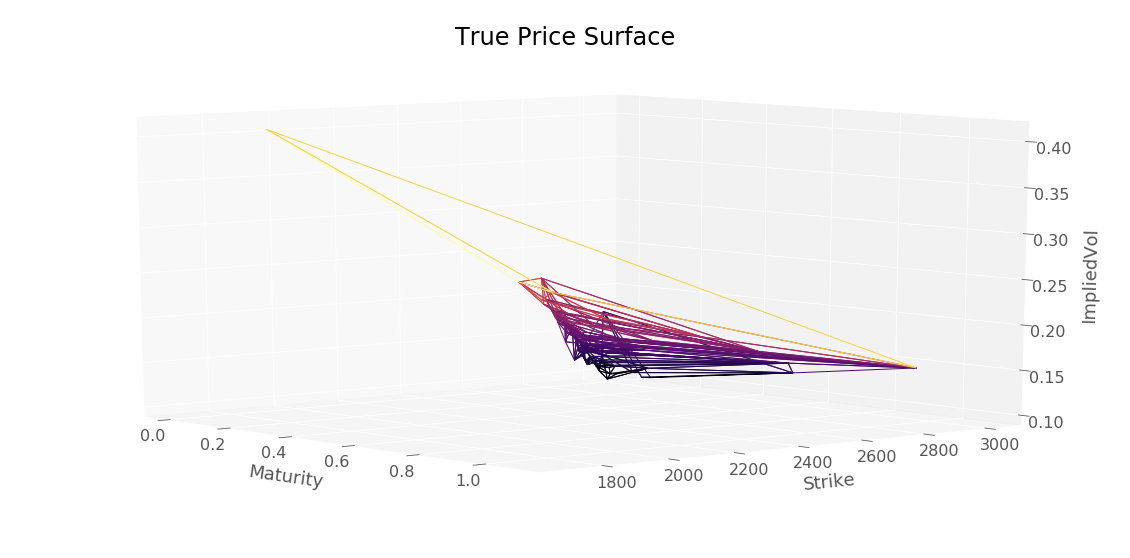

In [334]:
plotTools.plotSerie(getPut(trainingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

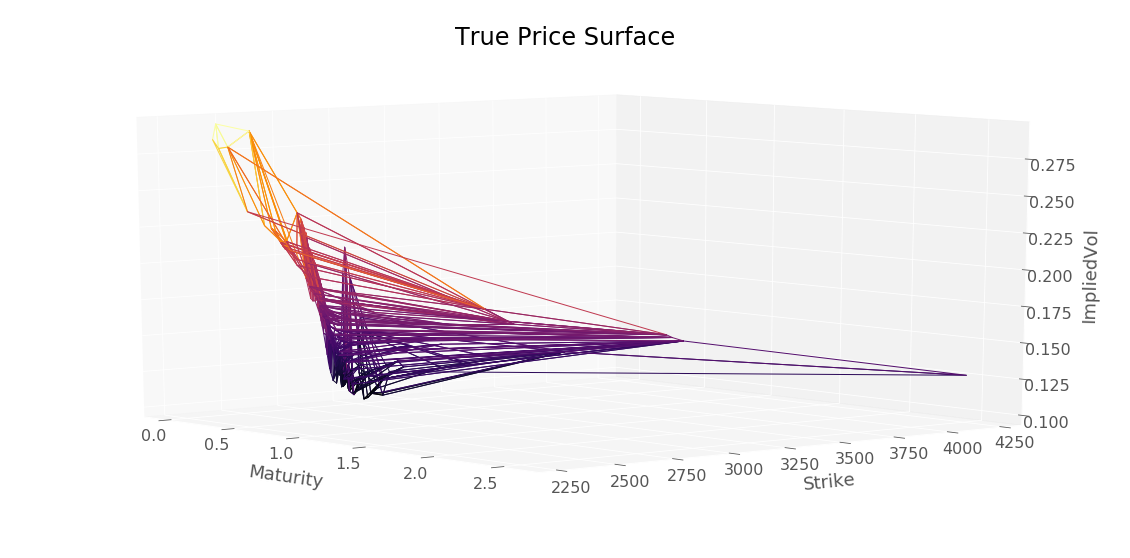

In [335]:
plotTools.plotSerie(getCall(testingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

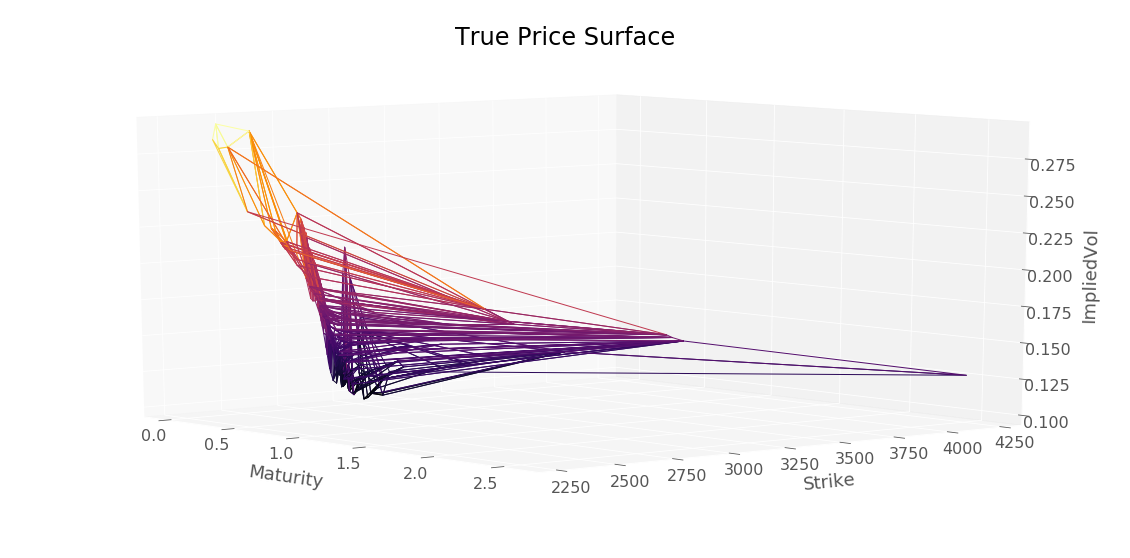

In [336]:
plotTools.plotSerie(getPut(testingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

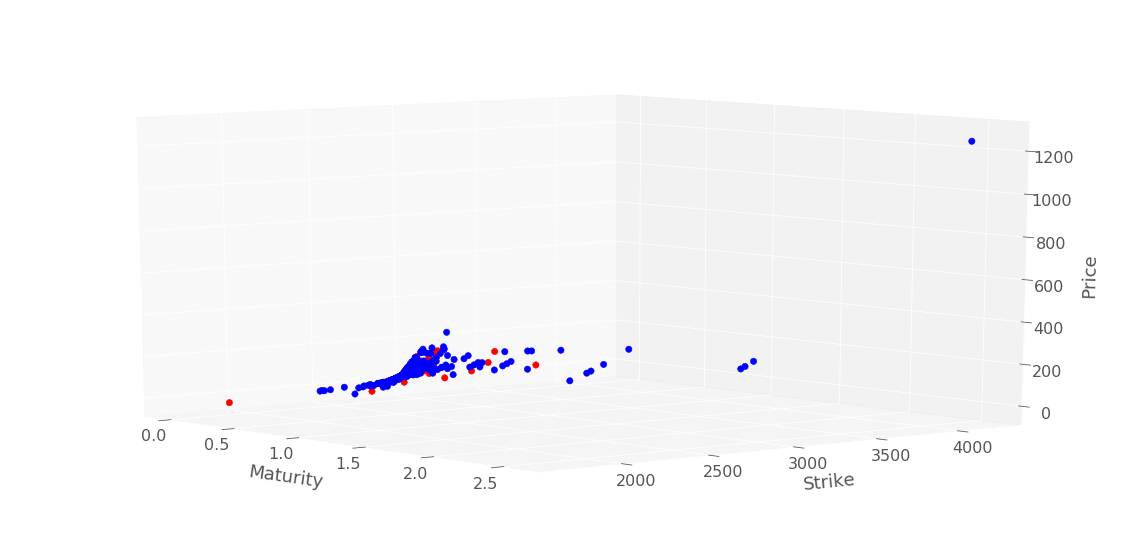

In [337]:
plotTools.plot2Series(getPut(testingSet)["Price"], 
                      getPut(trainingSet)["Price"], 
                      yMin=0,
                      yMax=3*S0, 
                      Title = 'True Price Surface')

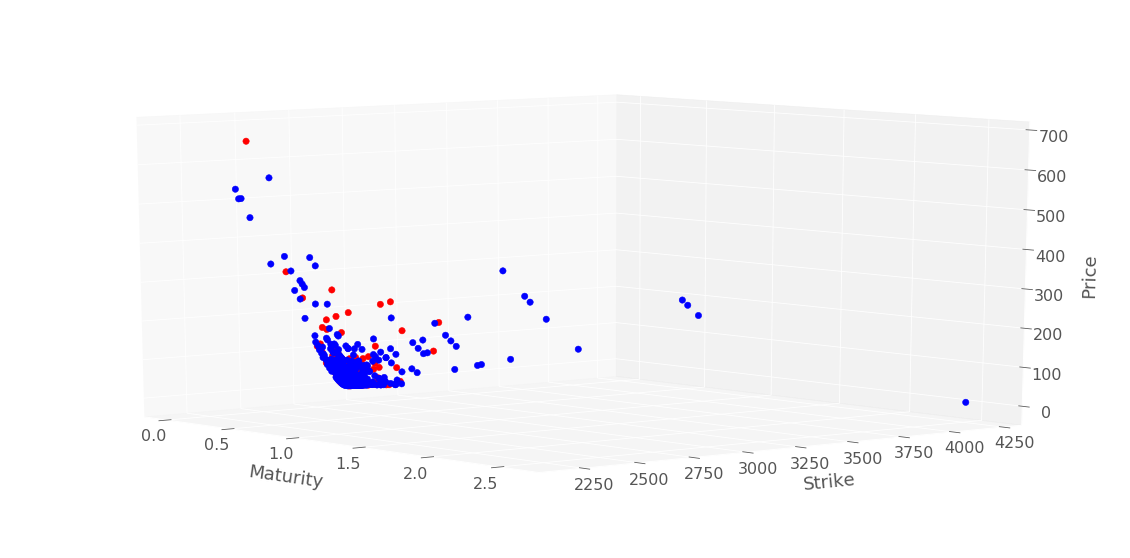

In [338]:
plotTools.plot2Series(getCall(testingSet)["Price"], 
                      getCall(trainingSet)["Price"], 
                      yMin=0,
                      yMax=3*S0,
                      Title = 'True Price Surface')

In [339]:
testingSet.shape

(666, 15)

In [340]:
trainingSet.shape

(223, 15)

In [341]:
dataSet.head()

,,Price,Delta,Vega,Delta Strike,Gamma Strike,Theta,ChangedStrike,DividendFactor,Strike,Maturity,ImpliedVol,VegaRef,OptionType,logMoneyness,impliedTotalVariance
Strike,Maturity,,,,,,,,,,,,,,,
1700.0,0.246,0.80,-0.004171,17.445534,0.009788,-0.000018,15.329284,1697.643924,0.997527,1700.0,0.246,0.4147,0.062925,-1.0,-0.521416,0.042306
2200.0,0.419,671.15,0.954106,178.246247,-2.775941,0.005611,-4731.157502,2194.553900,0.994628,2200.0,0.419,0.2550,169.246997,1.0,-0.264678,0.027245
2400.0,0.419,20.55,-0.099289,323.155078,0.185544,0.000106,187.583551,2394.058800,0.994628,2400.0,0.419,0.2264,368.610408,-1.0,-0.177667,0.021477
2550.0,0.112,318.35,0.937960,117.016911,-2.546618,0.009389,-8519.282870,2547.963157,1.000111,2550.0,0.112,0.2299,139.166804,1.0,-0.115363,0.005920
2625.0,0.112,247.60,0.896813,171.829491,-2.220371,0.009018,-5780.569433,2622.903250,1.000111,2625.0,0.112,0.2101,214.406617,1.0,-0.086375,0.004944


## Scaling methods

Use min-max of scaling strike between 0 et 1 for improving stability of neural network training. 

In [342]:
activateScaling = False
transformCustom = dataSetConstruction.transformCustomMinMax if activateScaling else dataSetConstruction.transformCustomId
inverseTransform = dataSetConstruction.inverseTransformMinMax if activateScaling else dataSetConstruction.inverseTransformId
inverseTransformColumn = dataSetConstruction.inverseTransformColumnMinMax if activateScaling else dataSetConstruction.inverseTransformColumnId
inverseTransformColumnGreeks = dataSetConstruction.inverseTransformColumnGreeksMinMax if activateScaling else dataSetConstruction.inverseTransformColumnGreeksId

In [343]:
scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataSet)
scaledDataSet = transformCustom(dataSet, scaler)
scaledDataSetTest = transformCustom(dataSetTest, scaler)

In [344]:
scaledDataSet.head()

,,Price,Delta,Vega,Delta Strike,Gamma Strike,Theta,ChangedStrike,DividendFactor,Strike,Maturity,ImpliedVol,VegaRef,OptionType,logMoneyness,impliedTotalVariance
Strike,Maturity,,,,,,,,,,,,,,,
1700.0,0.246,0.80,-0.004171,17.445534,0.009788,-0.000018,15.329284,1697.643924,0.997527,1700.0,0.246,0.4147,0.062925,-1.0,-0.521416,0.042306
2200.0,0.419,671.15,0.954106,178.246247,-2.775941,0.005611,-4731.157502,2194.553900,0.994628,2200.0,0.419,0.2550,169.246997,1.0,-0.264678,0.027245
2400.0,0.419,20.55,-0.099289,323.155078,0.185544,0.000106,187.583551,2394.058800,0.994628,2400.0,0.419,0.2264,368.610408,-1.0,-0.177667,0.021477
2550.0,0.112,318.35,0.937960,117.016911,-2.546618,0.009389,-8519.282870,2547.963157,1.000111,2550.0,0.112,0.2299,139.166804,1.0,-0.115363,0.005920
2625.0,0.112,247.60,0.896813,171.829491,-2.220371,0.009018,-5780.569433,2622.903250,1.000111,2625.0,0.112,0.2101,214.406617,1.0,-0.086375,0.004944


In [345]:
#Search strike for ATM option
midS0 = dataSet[dataSet.index.get_level_values("Strike") >= S0].index.get_level_values("Strike").min()

## Plot functions

In [346]:
KMin = 0#0.7 * S0[0]
KMax = 2.0 * S0#1.3 * S0[0]


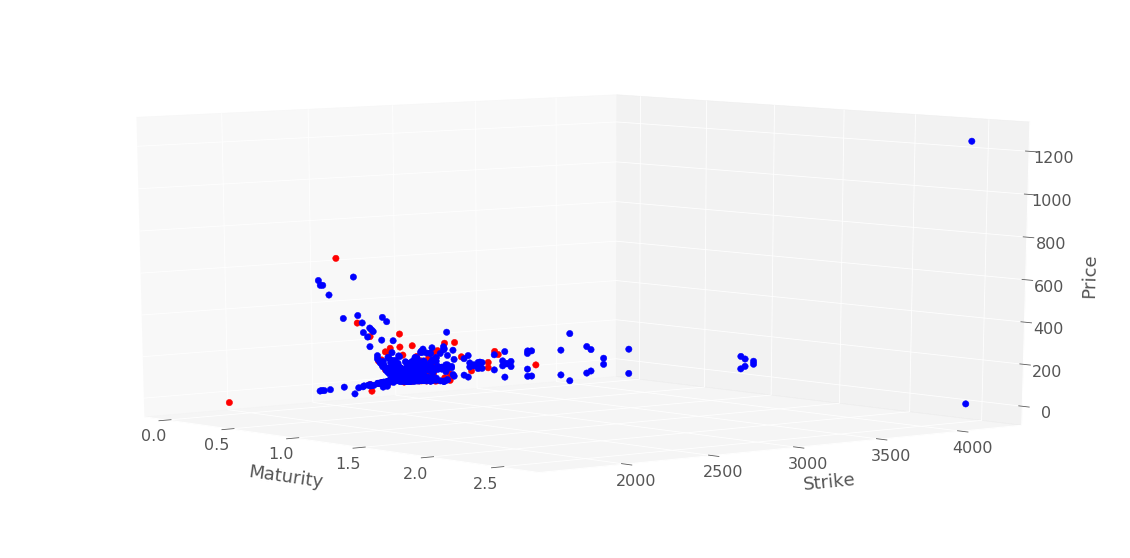

In [347]:
plotTools.plot2Series(dataSetTest[dataSetTest.Maturity > 0]["Price"], 
                      dataSet[dataSet.Maturity > 0]["Price"], 
                      yMin=KMin,
                      yMax=KMax, 
                      Title = 'True Price Surface')

In [348]:
importlib.reload(plotTools)

<module 'plotTools' from './code/plotTools.py'>

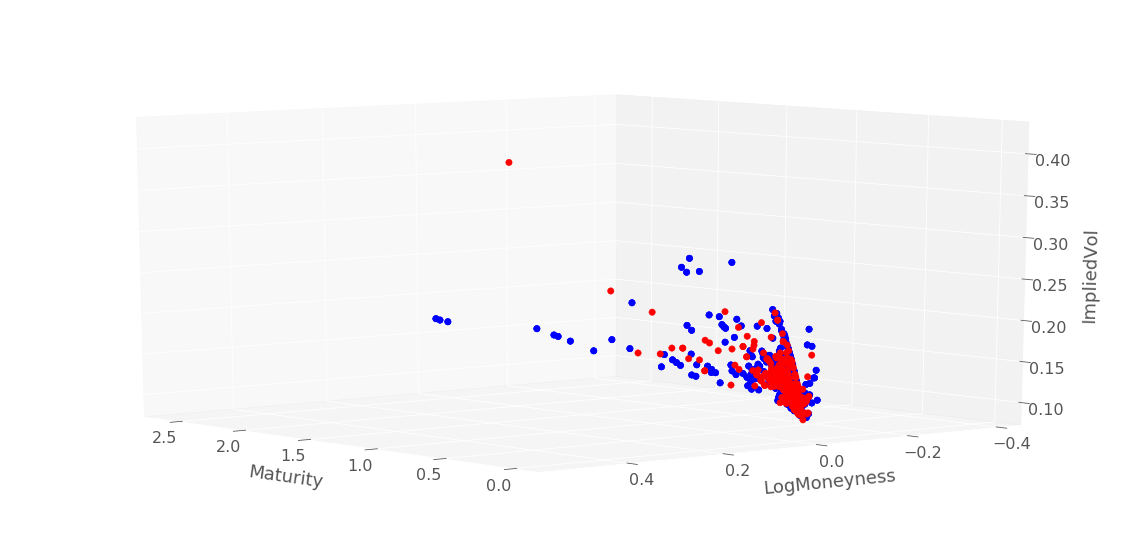

In [349]:
plotTools.plot2Series(plotTools.convertToLogMoneyness(dataSetTest[dataSetTest.Maturity > 0], S0)["ImpliedVol"], 
                      plotTools.convertToLogMoneyness(dataSet[dataSet.Maturity > 0], S0)["ImpliedVol"], 
                      yMin=-1000,
                      yMax=1000, 
                      Title = 'True Implied vol Surfaces', 
                      az=140)

In [350]:
plt.get_cmap("plasma")(0)

(0.050383, 0.029803, 0.527975, 1.0)

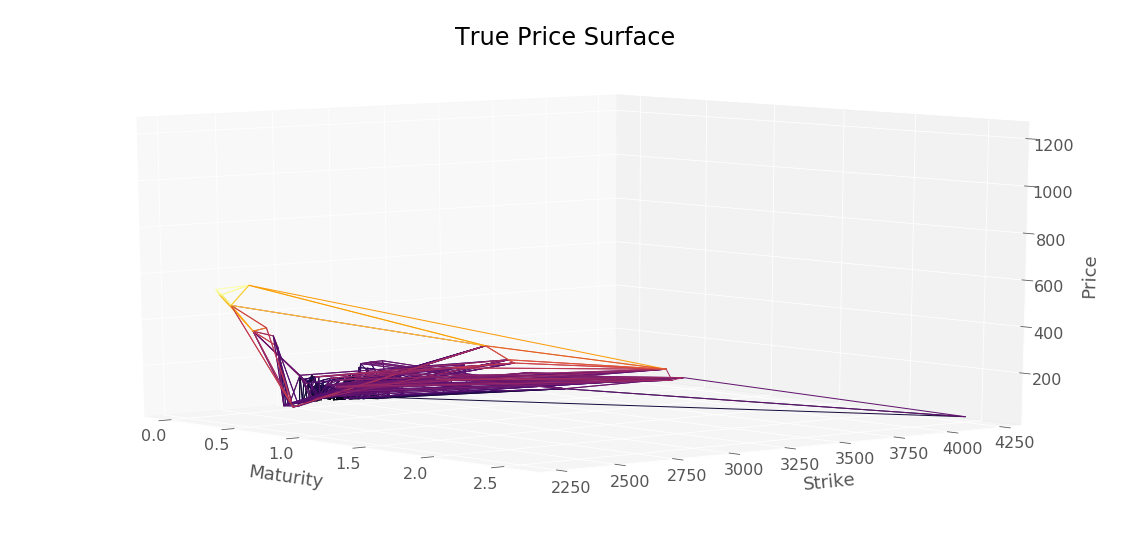

In [351]:
plotTools.plotSerie(dataSetTest[dataSetTest.Maturity > 0]["Price"], 
                    yMin=KMin,
                    yMax=KMax, 
                    Title = 'True Price Surface')

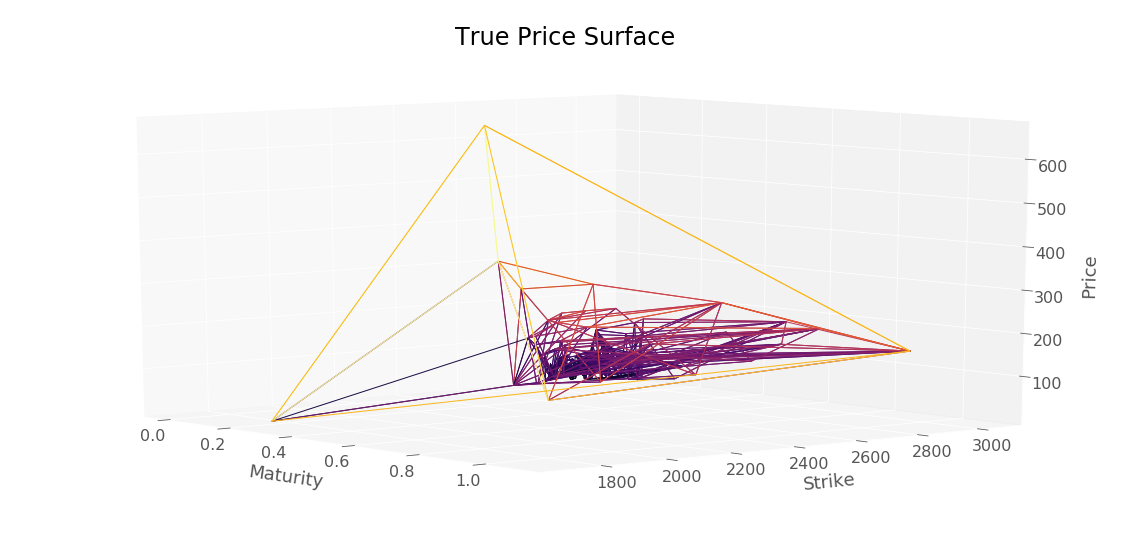

In [352]:
plotTools.plotSerie(dataSet["Price"],
                    yMin=KMin,
                    yMax=KMax, 
                    Title = 'True Price Surface')

In [353]:
inverseTransform(scaledDataSet, scaler).head()

,,Price,Delta,Vega,Delta Strike,Gamma Strike,Theta,ChangedStrike,DividendFactor,Strike,Maturity,ImpliedVol,VegaRef,OptionType,logMoneyness,impliedTotalVariance
Strike,Maturity,,,,,,,,,,,,,,,
1700.0,0.246,0.80,-0.004171,17.445534,0.009788,-0.000018,15.329284,1697.643924,0.997527,1700.0,0.246,0.4147,0.062925,-1.0,-0.521416,0.042306
2200.0,0.419,671.15,0.954106,178.246247,-2.775941,0.005611,-4731.157502,2194.553900,0.994628,2200.0,0.419,0.2550,169.246997,1.0,-0.264678,0.027245
2400.0,0.419,20.55,-0.099289,323.155078,0.185544,0.000106,187.583551,2394.058800,0.994628,2400.0,0.419,0.2264,368.610408,-1.0,-0.177667,0.021477
2550.0,0.112,318.35,0.937960,117.016911,-2.546618,0.009389,-8519.282870,2547.963157,1.000111,2550.0,0.112,0.2299,139.166804,1.0,-0.115363,0.005920
2625.0,0.112,247.60,0.896813,171.829491,-2.220371,0.009018,-5780.569433,2622.903250,1.000111,2625.0,0.112,0.2101,214.406617,1.0,-0.086375,0.004944


## Learning Price

In [ ]:
hyperparameters = {}
#penalization coefficient
hyperparameters["lambdaLocVol"] = 100
hyperparameters["lambdaSoft"] = 100 
hyperparameters["lambdaGamma"] = 10000

#Derivative soft constraints parameters
hyperparameters["lowerBoundTheta"] = 0.01
hyperparameters["lowerBoundGamma"] = 0.00001

#Local variance parameters
hyperparameters["DupireVarCap"] = 10
hyperparameters["DupireVolLowerBound"] = 0.05
hyperparameters["DupireVolUpperBound"] = 0.40

#Learning scheduler coefficient
hyperparameters["LearningRateStart"] = 0.1
hyperparameters["Patience"] = 100
hyperparameters["batchSize"] = 50
hyperparameters["FinalLearningRate"] = 1e-6
hyperparameters["FixedLearningRate"] = False

#Training parameters
hyperparameters["nbUnits"] = 200 #number of units for hidden layers
hyperparameters["maxEpoch"] = 10000 #maximum number of epochs

## Dupire formula implementation

### Hybrid architecture (Exact derivatives)

In [ ]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureConstrainedDupire,
                                       scaledDataSet,
                                       False, 
                                       hyperparameters,
                                       scaler,
                                       modelName = "convexHybridMatthewDupireVolModel")
y_pred2, volLocale2, dNN_T2, gNN_K2, lossSerie2 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie2)

In [ ]:
lossSerie2.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedDupire, 
                                      scaledDataSet, 
                                      False, 
                                      hyperparameters,
                                      scaler,
                                      modelName = "convexHybridMatthewDupireVolModel")
y_pred2, volLocale2, dNN_T2, gNN_K2, lossSerie2 = res
plotTools.modelSummary(y_pred2, 
                       volLocale2, 
                       dNN_T2, 
                       gNN_K2, 
                       dataSet)
impV2 = plotTools.plotImpliedVol(y_pred2, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap)
neuralNetwork.saveDataModel(y_pred2, 
                            volLocale2, 
                            impV2, 
                            "convexHybridMatthewDupireVolModelTrain")

In [ ]:
volLocale2.loc[(midS0,slice(None))]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedDupire, 
                                      scaledDataSetTest, 
                                      False, 
                                      hyperparameters,
                                      scaler,
                                      modelName = "convexHybridMatthewDupireVolModel")
y_pred2Test, volLocale2Test, dNN_T2Test, gNN_K2Test, lossSerie2Test = res
plotTools.modelSummary(y_pred2Test, 
                       volLocale2Test, 
                       dNN_T2Test, 
                       gNN_K2Test, 
                       dataSetTest)
impV2Test = plotTools.plotImpliedVol(y_pred2Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_pred2Test, 
                            impV2Test, 
                            impV2, 
                            "convexHybridMatthewDupireVolModelTest")

### Hybrid Network (Derivatives from algorithmic differentiation) 

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureConstrainedRawDupire,
                                       scaledDataSet,
                                       False, 
                                       hyperparameters,
                                       scaler,
                                       modelName = "convexHybridDupireVolModel")
y_pred3, volLocale3, dNN_T3, gNN_K3, lossSerie3 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie3)

In [ ]:
lossSerie3.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedRawDupire, 
                                      scaledDataSet, 
                                      False,
                                      hyperparameters,
                                      scaler,
                                      modelName = "convexHybridDupireVolModel")
y_pred3, volLocale3, dNN_T3, gNN_K3, lossSerie3 = res
plotTools.modelSummary(y_pred3, 
                       volLocale3, 
                       dNN_T3, 
                       gNN_K3, 
                       dataSet)
impV3 = plotTools.plotImpliedVol(y_pred3, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap)
neuralNetwork.saveDataModel(y_pred3, 
                            volLocale3, 
                            impV3, 
                            "convexHybridDupireVolModelTrain")

In [ ]:
volLocale3.loc[(midS0,slice(None))]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedRawDupire, 
                                      scaledDataSetTest, 
                                      False, 
                                      hyperparameters,
                                      scaler,
                                      modelName = "convexHybridDupireVolModel")
y_pred3Test, volLocale3Test, dNN_T3Test, gNN_K3Test, lossSerie3Test = res
plotTools.modelSummary(y_pred3Test, 
                       volLocale3Test, 
                       dNN_T3Test, 
                       gNN_K3Test, 
                       dataSetTest)
impV3Test = plotTools.plotImpliedVol(y_pred3Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_pred3Test, 
                            volLocale3Test, 
                            impV3Test, 
                            "convexHybridDupireVolModelTest")

In [ ]:

dNN_T3Test[dNN_T3Test<=0]

In [ ]:
plotTools.modelSummary(y_pred3, 
                       volLocale3, 
                       dNN_T3, 
                       gNN_K3, 
                       dataSet,
                       logMoneynessScale = True)
impV3 = plotTools.plotImpliedVol(y_pred3, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap,
                                 logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred3Test, 
                       volLocale3Test, 
                       dNN_T3Test, 
                       gNN_K3Test, 
                       dataSetTest,
                       logMoneynessScale = True)
impV3Test = plotTools.plotImpliedVol(y_pred3Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap,
                                     logMoneynessScale = True)

### Standard network with soft constraints

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureVanillaSoftDupire,
                                       scaledDataSet,
                                       False, 
                                       hyperparameters, 
                                       scaler,
                                       modelName = "convexSoftDupireVolModel")
y_pred4, volLocale4, dNN_T4, gNN_K4, lossSerie4 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie4)

In [ ]:
lossSerie4.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureVanillaSoftDupire,
                                      scaledDataSet, 
                                      False, 
                                      hyperparameters,
                                      scaler,
                                      modelName = "convexSoftDupireVolModel")
y_pred4, volLocale4, dNN_T4, gNN_K4, lossSerie4 = res
plotTools.modelSummary(y_pred4, 
                       volLocale4, 
                       dNN_T4, 
                       gNN_K4, 
                       dataSet)
impV4 = plotTools.plotImpliedVol(y_pred4, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap)
neuralNetwork.saveDataModel(y_pred4, 
                            volLocale4, 
                            impV4, 
                            "convexSoftDupireVolModelTrain")

In [ ]:
volLocale4.loc[(midS0,slice(None))]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureVanillaSoftDupire, 
                                      scaledDataSetTest, 
                                      False, 
                                      hyperparameters,
                                      scaler,
                                      modelName = "convexSoftDupireVolModel")
y_pred4Test, volLocale4Test, dNN_T4Test, gNN_K4Test, lossSerie4Test = res
plotTools.modelSummary(y_pred4Test, 
                       volLocale4Test, 
                       dNN_T4Test, 
                       gNN_K4Test, 
                       dataSetTest)
impV4Test = plotTools.plotImpliedVol(y_pred4Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_pred4Test, 
                            volLocale4Test, 
                            impV4Test, 
                            "convexSoftDupireVolModelTest")

In [ ]:
plotTools.modelSummary(y_pred4, 
                       volLocale4, 
                       dNN_T4, 
                       gNN_K4, 
                       dataSet,
                       logMoneynessScale = True)
impV4 = plotTools.plotImpliedVol(y_pred4, 
                       dataSet["ImpliedVol"], 
                       bootstrap,
                       logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred4Test, 
                       volLocale4Test, 
                       dNN_T4Test, 
                       gNN_K4Test, 
                       dataSetTest,
                       logMoneynessScale = True)
impV4Test = plotTools.plotImpliedVol(y_pred4Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap,
                                     logMoneynessScale = True)

### Unconstrained standard network

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureUnconstrainedDupire,
                                       scaledDataSet,
                                       False, 
                                       hyperparameters,
                                       scaler,
                                       modelName = "unconstrainedDupireVolModel")
y_pred5, volLocale5, dNN_T5, gNN_K5, lossSerie5 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie5)

In [ ]:
lossSerie5.iloc[-1]

In [1]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureUnconstrainedDupire,
                                      scaledDataSet,
                                      False,
                                      hyperparameters,
                                      scaler,
                                      modelName = "unconstrainedDupireVolModel")
y_pred5, volLocale5, dNN_T5, gNN_K5, lossSerie5 = res
plotTools.modelSummary(y_pred5, 
                       volLocale5, 
                       dNN_T5, 
                       gNN_K5, 
                       dataSet)
impV5 = plotTools.plotImpliedVol(y_pred5, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap)
neuralNetwork.saveDataModel(y_pred5, 
                            volLocale5, 
                            impV5, 
                            "unconstrainedDupireVolModelTrain")

NameError: name 'neuralNetwork' is not defined

In [ ]:
volLocale5.loc[(midS0,slice(None))]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureUnconstrainedDupire, 
                                      scaledDataSetTest, 
                                      False, 
                                      hyperparameters, 
                                      scaler,
                                      modelName = "unconstrainedDupireVolModel")
y_pred5Test, volLocale5Test, dNN_T5Test, gNN_K5Test, lossSerie5Test = res
plotTools.modelSummary(y_pred5Test, 
                       volLocale5Test, 
                       dNN_T5Test, 
                       gNN_K5Test, 
                       dataSetTest)
impV5Test = plotTools.plotImpliedVol(y_pred5Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_pred5Test, 
                            volLocale5Test, 
                            impV5Test, 
                            "unconstrainedDupireVolModelTest")

In [ ]:
plotTools.modelSummary(y_pred5, 
                       volLocale5, 
                       dNN_T5, 
                       gNN_K5, 
                       dataSet,
                       logMoneynessScale = True)
impV5 = plotTools.plotImpliedVol(y_pred5, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap,
                                 logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred5Test, 
                       volLocale5Test, 
                       dNN_T5Test, 
                       gNN_K5Test, 
                       dataSetTest,
                       logMoneynessScale = True)
impV5Test = plotTools.plotImpliedVol(y_pred5Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap,
                                     logMoneynessScale = True)

In [ ]:
dNN_T5TestLog = plotTools.convertToLogMoneyness(dNN_T5Test)
dNN_T5Log = plotTools.convertToLogMoneyness(dNN_T5)
gNN_K5TestLog = plotTools.convertToLogMoneyness(gNN_K5Test)
gNN_K5Log = plotTools.convertToLogMoneyness(gNN_K5)
testViolation = plotTools.convertToLogMoneyness(y_pred5Test)[(gNN_K5TestLog < 0) + (dNN_T5TestLog < 0)]
trainViolation = plotTools.convertToLogMoneyness(y_pred5)[(gNN_K5Log < 0) + (dNN_T5Log < 0)]

In [ ]:
trainViolation

In [ ]:
priceTrain = plotTools.convertToLogMoneyness(y_pred5) 
plotTools.plot2Series(plotTools.convertToLogMoneyness(y_pred5Test), 
                      priceTrain,
                      testViolation,
                      trainViolation,
                      Title = '',
                      yMin = -1000,
                      az=140)

### Hard constrained architecture

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureHardConstrainedDupire,
                                       scaledDataSet,
                                       False, 
                                       hyperparameters, 
                                       scaler,
                                       modelName = "convexHardDupireVolModel")
y_pred6, volLocale6, dNN_T6, gNN_K6, lossSerie6 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie6)

In [ ]:
lossSerie6.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureHardConstrainedDupire, 
                                      scaledDataSet, 
                                      False, 
                                      hyperparameters, 
                                      scaler,
                                      modelName = "convexHardDupireVolModel")
y_pred6, volLocale6, dNN_T6, gNN_K6, lossSerie6 = res
plotTools.modelSummary(y_pred6, 
                       volLocale6, 
                       dNN_T6, 
                       gNN_K6, 
                       dataSet)
impV6 = plotTools.plotImpliedVol(y_pred6, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap)
neuralNetwork.saveDataModel(y_pred6, 
                            volLocale6, 
                            impV6, 
                            "convexHardDupireVolModelTrain")

In [ ]:
volLocale6.loc[(midS0,slice(None))]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureHardConstrainedDupire,
                                      scaledDataSetTest, 
                                      False, 
                                      hyperparameters,
                                      scaler,
                                      modelName = "convexHardDupireVolModel")
y_pred6Test, volLocale6Test, dNN_T6Test, gNN_K6Test, lossSerie6Test = res
plotTools.modelSummary(y_pred6Test, 
                       volLocale6Test, 
                       dNN_T6Test, 
                       gNN_K6Test, 
                       dataSetTest)
impV6Test = plotTools.plotImpliedVol(y_pred6Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_pred6Test, 
                            volLocale6Test, 
                            impV6Test, 
                            "convexHardDupireVolModelTest")

In [ ]:
plotTools.modelSummary(y_pred6, 
                       volLocale6, 
                       dNN_T6, 
                       gNN_K6, 
                       dataSet)
impV6 = plotTools.plotImpliedVol(y_pred6, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap,
                                 logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred6Test, 
                       volLocale6Test, 
                       dNN_T6Test, 
                       gNN_K6Test, 
                       dataSetTest)
impV6Test = plotTools.plotImpliedVol(y_pred6Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap,
                                     logMoneynessScale = True)

## Dupire regularization 

Same lines as above except that dupire regularization is now activated.

### Hybrid architecture (Exact derivatives)

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureConstrainedDupire,
                                       scaledDataSet,
                                       True, 
                                       hyperparameters, 
                                       scaler,
                                       modelName = "regularizedConvexHybridMatthewDupireVolModel")
y_pred8, volLocale8, dNN_T8, gNN_K8, lossSerie8 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie8)

In [ ]:
lossSerie8.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedDupire, 
                                      scaledDataSet, 
                                      True, 
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexHybridMatthewDupireVolModel")
res = y_pred8, volLocale8, dNN_T8, gNN_K8, lossSerie8
plotTools.modelSummary(y_pred8, 
                       volLocale8, 
                       dNN_T8, 
                       gNN_K8, 
                       dataSet)
impV8 = plotTools.plotImpliedVol(y_pred8, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap)
neuralNetwork.saveDataModel(y_pred8, 
                            volLocale8, 
                            impV8, 
                            "regularizedConvexHybridMatthewDupireVolModelTrain")

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedDupire, 
                                      scaledDataSetTest, 
                                      True, 
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexHybridMatthewDupireVolModel")
y_pred8Test, volLocale8Test, dNN_T8Test, gNN_K8Test, lossSerie8Test = res
plotTools.modelSummary(y_pred8Test, 
                       volLocale8Test, 
                       dNN_T8Test, 
                       gNN_K8Test, 
                       dataSetTest)
impV8Test = plotTools.plotImpliedVol(y_pred8Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_pred8Test, 
                            volLocale8Test, 
                            impV8Test, 
                            "regularizedConvexHybridMatthewDupireVolModelTest")

### Unconstrained standard network

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureUnconstrainedDupire,
                                       scaledDataSet,
                                       True, 
                                       hyperparameters, 
                                       scaler,
                                       modelName = "regularizedUnconstrainedDupireVolModel")
y_pred9, volLocale9, dNN_T9, gNN_K9, lossSerie9 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie9)

In [ ]:
lossSerie9.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureUnconstrainedDupire, 
                                      scaledDataSet, 
                                      True, 
                                      hyperparameters,
                                      scaler,
                                      modelName = "regularizedUnconstrainedDupireVolModel")
y_pred9, volLocale9, dNN_T9, gNN_K9, lossSerie9 = res
plotTools.modelSummary(y_pred9, 
                       volLocale9, 
                       dNN_T9, 
                       gNN_K9, 
                       dataSet)
impV9 = plotTools.plotImpliedVol(y_pred9, 
                                 dataSet["ImpliedVol"], 
                                 bootstrap)
neuralNetwork.saveDataModel(y_pred9, 
                            volLocale9, 
                            impV9, 
                            "regularizedUnconstrainedDupireVolModelTrain")

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureUnconstrainedDupire, 
                                      scaledDataSetTest, 
                                      True, 
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedUnconstrainedDupireVolModel")
y_pred9Test, volLocale9Test, dNN_T9Test, gNN_K9Test, lossSerie9Test = res
plotTools.modelSummary(y_pred9Test, 
                       volLocale9Test, 
                       dNN_T9Test, 
                       gNN_K9Test, 
                       dataSetTest)
impV9Test = plotTools.plotImpliedVol(y_pred9Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_pred9Test, 
                            volLocale9Test, 
                            impV9Test, 
                            "regularizedUnconstrainedDupireVolModelTest")

In [ ]:
plotTools.modelSummary(y_pred9, 
             volLocale9, 
             dNN_T9, 
             gNN_K9, 
             dataSet,
             logMoneynessScale = True)
impV9 = plotTools.plotImpliedVol(y_pred9, 
                       dataSet["ImpliedVol"], 
                       bootstrap,
                       logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred9Test, 
                       volLocale9Test, 
                       dNN_T9Test, 
                       gNN_K9Test, 
                       dataSetTest,
                       logMoneynessScale = True)
impV9Test = plotTools.plotImpliedVol(y_pred9Test, 
                                     dataSetTest["ImpliedVol"], 
                                     bootstrap,
                                     logMoneynessScale = True)

In [ ]:
dNN_T9TestLog = plotTools.convertToLogMoneyness(dNN_T9Test)
dNN_T9Log = plotTools.convertToLogMoneyness(dNN_T9)
gNN_K9TestLog = plotTools.convertToLogMoneyness(gNN_K9Test)
gNN_K9Log = plotTools.convertToLogMoneyness(gNN_K9)
testViolation = plotTools.convertToLogMoneyness(y_pred9Test)[(gNN_K9TestLog < 0) + (dNN_T9TestLog < 0)]
trainViolation = plotTools.convertToLogMoneyness(y_pred9)[(gNN_K9Log < 0) + (dNN_T9Log < 0)]

In [ ]:
priceTrain = plotTools.convertToLogMoneyness(y_pred9) 
plotTools.plot2Series(plotTools.convertToLogMoneyness(y_pred9Test), 
                      priceTrain,
                      testViolation,
                      trainViolation,
                      Title = '',
                      yMin = -1000,
                      az=140)

### Hybrid Network (Derivatives from algorithmic differentiation) 

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureConstrainedRawDupire,
                                       scaledDataSet,
                                       True,
                                       hyperparameters, 
                                       scaler,
                                       modelName = "regularizedConvexHybridDupireVolModel")
y_pred10, volLocale10, dNN_T10, gNN_K10, lossSerie10 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie10)

In [ ]:
lossSerie10.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedRawDupire,
                                      scaledDataSet,
                                      True,
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexHybridDupireVolModel")
y_pred10, volLocale10, dNN_T10, gNN_K10, lossSerie10 = res
plotTools.modelSummary(y_pred10, 
                       volLocale10, 
                       dNN_T10, 
                       gNN_K10, 
                       dataSet)
impV10 = plotTools.plotImpliedVol(y_pred10, 
                                  dataSet["ImpliedVol"], 
                                  bootstrap)
neuralNetwork.saveDataModel(y_pred10, 
                            volLocale10, 
                            impV10, 
                            "regularizedConvexHybridDupireVolModelTrain")

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureConstrainedRawDupire,
                                      scaledDataSetTest,
                                      True,
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexHybridDupireVolModel")
y_pred10Test, volLocale10Test, dNN_T10Test, gNN_K10Test, lossSerie10Test = res
plotTools.modelSummary(y_pred10Test, 
                       volLocale10Test, 
                       dNN_T10Test, 
                       gNN_K10Test, 
                       dataSetTest)
impV10Test = plotTools.plotImpliedVol(y_pred10Test, 
                                      dataSetTest["ImpliedVol"], 
                                      bootstrap)
neuralNetwork.saveDataModel(y_pred10Test, 
                            volLocale10Test, 
                            impV10Test, 
                            "regularizedConvexHybridDupireVolModelTest")

In [ ]:
plotTools.modelSummary(y_pred10, 
                       volLocale10, 
                       dNN_T10, 
                       gNN_K10, 
                       dataSet,
                       logMoneynessScale = True)
impV10 = plotTools.plotImpliedVol(y_pred10, 
                                  dataSet["ImpliedVol"], 
                                  bootstrap,
                                  logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred10Test, 
                       volLocale10Test, 
                       dNN_T10Test, 
                       gNN_K10Test, 
                       dataSetTest,
                       logMoneynessScale = True)
impV10Test = plotTools.plotImpliedVol(y_pred10Test, 
                                      dataSetTest["ImpliedVol"], 
                                      bootstrap,
                                      logMoneynessScale = True)

### Standard network with soft constraints

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureVanillaSoftDupire,
                                       scaledDataSet,
                                       True,
                                       hyperparameters,
                                       scaler,
                                       modelName = "regularizedConvexSoftDupireVolModel")
y_pred11, volLocale11, dNN_T11, gNN_K11, lossSerie11 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie11)

In [ ]:
lossSerie11.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureVanillaSoftDupire,
                                      scaledDataSet,
                                      True,
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexSoftDupireVolModel")
y_pred11, volLocale11, dNN_T11, gNN_K11, lossSerie11 = res
plotTools.modelSummary(y_pred11, 
                       volLocale11, 
                       dNN_T11, 
                       gNN_K11, 
                       dataSet)
impV11 = plotTools.plotImpliedVol(y_pred11, 
                                  dataSet["ImpliedVol"], 
                                  bootstrap)
neuralNetwork.saveDataModel(y_pred11, 
                            volLocale11, 
                            impV11, 
                            "regularizedConvexHybridDupireVolModelTrain")

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureVanillaSoftDupire,
                                      scaledDataSetTest,
                                      True,
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexSoftDupireVolModel")
y_pred11Test, volLocale11Test, dNN_T11Test, gNN_K11Test, lossSerie11Test = res
plotTools.modelSummary(y_pred11Test, 
                       volLocale11Test, 
                       dNN_T11Test, 
                       gNN_K11Test, 
                       dataSetTest)
impV11Test = plotTools.plotImpliedVol(y_pred11Test, 
                                      dataSetTest["ImpliedVol"], 
                                      bootstrap)
neuralNetwork.saveDataModel(y_pred11Test, 
                            volLocale11Test, 
                            impV11Test, 
                            "regularizedConvexHybridDupireVolModelTest")

In [ ]:
plotTools.modelSummary(y_pred11, 
                       volLocale11, 
                       dNN_T11, 
                       gNN_K11, 
                       dataSet,
                       logMoneynessScale = True)
impV11 = plotTools.plotImpliedVol(y_pred11, 
                                  dataSet["ImpliedVol"], 
                                  bootstrap,
                                  logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred11Test, 
                       volLocale11Test, 
                       dNN_T11Test, 
                       gNN_K11Test, 
                       dataSetTest,
                       logMoneynessScale = True)
impV11Test = plotTools.plotImpliedVol(y_pred11Test, 
                                      dataSetTest["ImpliedVol"], 
                                      bootstrap,
                                      logMoneynessScale = True)

### Hard constrained architecture

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureHardConstrainedDupire,
                                       scaledDataSet,
                                       True,
                                       hyperparameters, 
                                       scaler,
                                       modelName = "regularizedConvexHardDupireVolModel")
y_pred12, volLocale12, dNN_T12, gNN_K12, lossSerie12 = res

In [ ]:
plotTools.plotEpochLoss(lossSerie12)

In [ ]:
lossSerie12.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureHardConstrainedDupire,
                                      scaledDataSet,
                                      True,
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexHardDupireVolModel")
y_pred12, volLocale12, dNN_T12, gNN_K12, lossSerie12 = res
plotTools.modelSummary(y_pred12, 
                       volLocale12, 
                       dNN_T12, 
                       gNN_K12,
                       dataSet)
impV12 = plotTools.plotImpliedVol(y_pred12, 
                                  dataSet["ImpliedVol"], 
                                  bootstrap)
neuralNetwork.saveDataModel(y_pred12, 
                            volLocale12, 
                            impV12, 
                            "regularizedConvexHardDupireVolModelTrain")

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureHardConstrainedDupire,
                                      scaledDataSetTest,
                                      True,
                                      hyperparameters, 
                                      scaler,
                                      modelName = "regularizedConvexHardDupireVolModel")
y_pred12Test, volLocale12Test, dNN_T12Test, gNN_K12Test, lossSerie12Test = res
plotTools.modelSummary(y_pred12Test, 
                       volLocale12Test, 
                       dNN_T12Test, 
                       gNN_K12Test, 
                       dataSetTest)
plotTools.impV12Test = plotImpliedVol(y_pred12Test, 
                                      dataSetTest["ImpliedVol"], 
                                      bootstrap)
neuralNetwork.saveDataModel(y_pred12Test, 
                            volLocale12Test, 
                            impV12Test, 
                            "regularizedConvexHardDupireVolModelTest")

In [ ]:
plotTools.modelSummary(y_pred12, 
                       volLocale12, 
                       dNN_T12, 
                       gNN_K12, 
                       dataSet,
                       logMoneynessScale = True)
impV12 = plotTools.plotImpliedVol(y_pred12, 
                                  dataSet["ImpliedVol"], 
                                  bootstrap,
                                  logMoneynessScale = True)

In [ ]:
plotTools.modelSummary(y_pred12Test, 
                       volLocale12Test, 
                       dNN_T12Test, 
                       gNN_K12Test, 
                       dataSetTest,
                       logMoneynessScale = True)
impV12Test = plotTools.plotImpliedVol(y_pred12Test, 
                                      dataSetTest["ImpliedVol"], 
                                      bootstrap,
                                      logMoneynessScale = True)

## Monte Carlo pricing

### Monte Carlo with implied vol

In [ ]:
nbTimeStep = 100
nbPaths = 100000

In [ ]:
mcResRefTrain = MonteCarloPricerVectorizedImplicit(S0[0],
                                                   dataSet,
                                                   bootstrap,
                                                   nbPaths,
                                                   nbTimeStep)
mcResRefTrain.head()

In [ ]:
plotTools.predictionDiagnosis(mcResRefTrain, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResRefTrain.to_csv("mcResRefTrain.csv")

In [ ]:
mcResRefTest = MonteCarloPricerVectorizedImplicit(S0[0],
                                                  dataSetTest,
                                                  bootstrap,
                                                  nbPaths,
                                                  nbTimeStep)
mcResRefTest.head()

In [ ]:
plotTools.predictionDiagnosis(mcResRefTest, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResRefTest.to_csv("mcResRefTest.csv")

### Monte Carlo local volatility

#### Constant local volatility

In [ ]:
def volLocaleTest(S, T):
    return np.ones_like(S) * 0.23
nbTimeStep = 100
nbPaths = 100000

In [ ]:
mcResSigmaRef = backtest.MonteCarloPricerVectorized(S0[0],
                                                    dataSetTest,
                                                    bootstrap,
                                                    nbPaths,
                                                    nbTimeStep,
                                                    volLocaleTest)
mcResSigmaRef.head()

In [ ]:
plotTools.predictionDiagnosis(mcResSigmaRef, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResSigmaRef.to_csv("mcResSigmaRef.csv")

#### Extracting neural local volatility





In [ ]:
strikeLow = dataSet["Strike"].min()#min(dataSet["Strike"].min(),dataSetTest["Strike"].min())
strikeUp = dataSet["Strike"].max()#max(dataSet["Strike"].max(),dataSetTest["Strike"].max())
strikeGrid = np.linspace(strikeLow, strikeUp, 100)
matLow = dataSet["Maturity"].min()#min(dataSet["Maturity"].min(),dataSetTest["Maturity"].min())
matUp = dataSet["Maturity"].max()#max(dataSet["Maturity"].max(),dataSetTest["Maturity"].max())
matGrid = np.linspace(matLow, matUp, 100)
volLocaleGrid = np.meshgrid(strikeGrid, matGrid)

##### Standard network, soft constraints

In [ ]:
def neuralVolLocale(s,t):
    vLoc = neuralNetwork.evalVolLocale(neuralNetwork.NNArchitectureVanillaSoftDupire,
                                       s, t,
                                       dataSetTest,
                                       hyperparameters,
                                       scaler,
                                       modelName = "convexSoftDupireVolModel")
    return vLoc.dropna()

In [ ]:
volLocalInterp = neuralVolLocale(volLocaleGrid[0].flatten(), 
                                 volLocaleGrid[1].flatten())
volLocalInterp.head()

In [ ]:
volLocalInterp.to_csv("convexSoftDupireVolModelVolLocalGrid.csv")

In [ ]:
volLocalInterp2 = neuralVolLocale(dataSetTest.index.get_level_values("Strike").values.flatten(), 
                                  dataSetTest.index.get_level_values("Maturity").values.flatten())
volLocalInterp2.head()

In [ ]:
volLocalInterp2.to_csv("convexSoftDupireVolModeldataSetTest.csv")

In [ ]:
nnVolLocale = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp, x, y)

In [ ]:
nnVolLocale2 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp2, x, y)

In [ ]:
plotTools.plotSerie(volLocalInterp,
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(nnVolLocale2(volLocaleGrid[0].flatten(), volLocaleGrid[1].flatten()),
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(volLocalInterp2,
                    Title = 'Testing Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(dataSetTest["locvol"],
                    Title = 'Testing Tikhonov Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(dataSet["locvol"],
                    Title = 'Tikohnov Train Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(neuralVolLocale(dataSet.index.get_level_values("Strike").values.flatten(), 
                                    dataSet.index.get_level_values("Maturity").values.flatten()),
                    Title = 'Training Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(localVolatility["LocalVolatility"],
                    Title = 'Complete tikhonov Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
localVolatility.head()

##### Hard constraint Regularized

In [ ]:
def neuralVolLocaleHardReg(s,t):
    vLoc = neuralNetwork.evalVolLocale(neuralNetwork.NNArchitectureHardConstrainedDupire,
                                       s, t,
                                       dataSet,
                                       hyperparameters,
                                       scaler,
                                       modelName = "regularizedConvexHardDupireVolModel")
    return vLoc

In [ ]:
volLocalInterp3 = neuralVolLocaleHardReg(volLocaleGrid[0].flatten(),
                                         volLocaleGrid[1].flatten())
volLocalInterp3.head()

In [ ]:
volLocalInterp3.to_csv("regularizedConvexHardDupireVolModelVolLocalGrid.csv")

In [ ]:
volLocalInterp4 = neuralVolLocaleHardReg(dataSetTest.index.get_level_values("Strike").values.flatten(),
                                         dataSetTest.index.get_level_values("Maturity").values.flatten())
volLocalInterp4.head()

In [ ]:
volLocalInterp4.to_csv("regularizedConvexHardDupireVolModeldataSetTest.csv")

In [ ]:
nnVolLocale3 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp3, x, y)

In [ ]:
nnVolLocale4 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp4, x, y)

In [ ]:
plotTools.plotSerie(volLocalInterp3,
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(volLocalInterp4,
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

##### Hard constraint

In [ ]:
def neuralVolLocaleHard(s,t):
    vLoc = neuralNetwork.evalVolLocale(neuralNetwork.NNArchitectureHardConstrainedDupire,
                                       s, t,
                                       dataSet,
                                       hyperparameters,
                                       scaler,
                                       modelName = "convexHardDupireVolModel")
    return vLoc

In [ ]:
volLocalInterp5 = neuralVolLocaleHard(volLocaleGrid[0].flatten(),
                                      volLocaleGrid[1].flatten())
volLocalInterp5.head()

In [ ]:
volLocalInterp5.to_csv("convexHardDupireVolModelVolLocalGrid.csv")

In [ ]:
volLocalInterp6 = neuralVolLocaleHard(dataSetTest.index.get_level_values("Strike").values.flatten(),
                                      dataSetTest.index.get_level_values("Maturity").values.flatten())
volLocalInterp6.head()

In [ ]:
volLocalInterp6.to_csv("convexHardDupireVolModeldataSetTest.csv")

In [ ]:
nnVolLocale5 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp5, x, y)

In [ ]:
nnVolLocale6 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp6, x, y)

In [ ]:
plotTools.plotSerie(volLocalInterp5,
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(volLocalInterp6,
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

#### Tikhonov local volatility

In [ ]:
nnTikhonov = lambda x,y : backtest.interpolatedMCLocalVolatility(localVolatility["LocalVolatility"], x, y)

In [ ]:
mcResTikhonovTest = backtest.MonteCarloPricerVectorized(S0[0],
                                                        dataSetTest,
                                                        bootstrap,
                                                        nbPaths,
                                                        nbTimeStep,
                                                        nnTikhonov)
mcResTikhonovTest.head()

In [ ]:
plotTools.predictionDiagnosis(mcResTikhonovTest, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResTikhonovTest.to_csv("mcResTikhonovTest.csv")

In [ ]:
mcResTikhonovTrain = backtest.MonteCarloPricerVectorized(S0[0],
                                                         dataSet,
                                                         bootstrap,
                                                         nbPaths,
                                                         nbTimeStep,
                                                         nnTikhonov)
mcResTikhonovTrain.head()

In [ ]:
plotTools.predictionDiagnosis(mcResTikhonovTrain, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResTikhonovTrain.to_csv("mcResTikhonovTrain.csv")

#### Neural local Volatility

##### Standard Network soft constraint

In [ ]:
mcResVolLocaleTest = backtest.MonteCarloPricerVectorized(S0[0],
                                                         dataSetTest,
                                                         bootstrap,
                                                         nbPaths,
                                                         nbTimeStep,
                                                         nnVolLocale)
mcResVolLocaleTest.head()

In [ ]:
mcResVolLocaleTest.to_csv("mcResVolLocaleTest.csv")

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocaleTest, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocaleTrain = backtest.MonteCarloPricerVectorized(S0[0],
                                                          dataSet,
                                                          bootstrap,
                                                          nbPaths,
                                                          nbTimeStep,
                                                          nnVolLocale)
mcResVolLocaleTrain.head()

In [ ]:
mcResVolLocaleTrain.to_csv("mcResVolLocaleTrain.csv")

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocaleTrain, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocaleTest2 = backtest.MonteCarloPricerVectorized(S0[0],
                                                          dataSetTest,
                                                          bootstrap,
                                                          nbPaths,
                                                          nbTimeStep,
                                                          nnVolLocale2)
mcResVolLocaleTest2.head()

In [ ]:
mcResVolLocaleTest2.to_csv("mcResVolLocaleTest2.csv")

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocaleTest2, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocaleTrain2 = backtest.MonteCarloPricerVectorized(S0[0],
                                                           dataSet,
                                                           bootstrap,
                                                           nbPaths,
                                                           nbTimeStep,
                                                           nnVolLocale2)
mcResVolLocaleTrain2.head()

In [ ]:
mcResVolLocaleTrain2.to_csv("mcResVolLocaleTrain2.csv")

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocaleTrain2, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
dataSetTest.tail()

##### Hard constraint Regularized

In [ ]:
mcResVolLocale3Train = backtest.MonteCarloPricerVectorized(S0[0],
                                                           dataSet,
                                                           bootstrap,
                                                           nbPaths,
                                                           nbTimeStep,
                                                           nnVolLocale3)
mcResVolLocale3Train.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale3Train, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale3Train.to_csv("mcResVolLocale3Train.csv")

In [ ]:
mcResVolLocale3Test = backtest.MonteCarloPricerVectorized(S0[0],
                                                          dataSetTest,
                                                          bootstrap,
                                                          nbPaths,
                                                          nbTimeStep,
                                                          nnVolLocale3)
mcResVolLocale3Test.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale3Test, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale3Test.to_csv("mcResVolLocale3Test.csv")

In [ ]:
mcResVolLocale4Train = backtest.MonteCarloPricerVectorized(S0[0],
                                                           dataSet,
                                                           bootstrap,
                                                           nbPaths,
                                                           nbTimeStep,
                                                           nnVolLocale4)
mcResVolLocale4Train.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale4Train, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale4Train.to_csv("mcResVolLocale4Train.csv")

In [ ]:
mcResVolLocale4Test = backtest.MonteCarloPricerVectorized(S0[0],
                                                          dataSetTest,
                                                          bootstrap,
                                                          nbPaths,
                                                          nbTimeStep,
                                                          nnVolLocale4)
mcResVolLocale4Test.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale4Test, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale4Test.to_csv("mcResVolLocale4Test.csv")

##### Hard constraint

In [ ]:
mcResVolLocale5Test = backtest.MonteCarloPricerVectorized(S0[0],
                                                          dataSetTest,
                                                          bootstrap,
                                                          nbPaths,
                                                          nbTimeStep,
                                                          nnVolLocale5)
mcResVolLocale5Test.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale5Test, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale5Test.to_csv("mcResVolLocale5Test.csv")

In [ ]:
mcResVolLocale5Train = backtest.MonteCarloPricerVectorized(S0[0],
                                                           dataSet,
                                                           bootstrap,
                                                           nbPaths,
                                                           nbTimeStep,
                                                           nnVolLocale5)
mcResVolLocale5Train.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale5Train, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale5Train.to_csv("mcResVolLocale5Train.csv")

In [ ]:
mcResVolLocale6Test = backtest.MonteCarloPricerVectorized(S0[0],
                                                          dataSetTest,
                                                          bootstrap,
                                                          nbPaths,
                                                          nbTimeStep,
                                                          nnVolLocale6)
mcResVolLocale6Test.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale6Test, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale6Test.to_csv("mcResVolLocale6Test.csv")

In [ ]:
mcResVolLocale6Train = backtest.MonteCarloPricerVectorized(S0[0],
                                                           dataSet,
                                                           bootstrap,
                                                           nbPaths,
                                                           nbTimeStep,
                                                           nnVolLocale6)
mcResVolLocale6Train.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale6Train, 
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale6Train.to_csv("mcResVolLocale6Train.csv")

## Hyperparameter selection

In [ ]:
selectHyperparametersRandom(hyperparameters,
                            ["lambdaLocVol","lambdaSoft","lambdaGamma"],
                            NNArchitectureConstrainedRawDupire,
                            "hyperParameters",
                            True, 
                            100,
                            logGrid = True)

In [ ]:

hyperparameters["lambdaLocVol"] = 100
hyperparameters["lambdaSoft"] = 100 
hyperparameters["lambdaGamma"] = 10000

In [ ]:
selectHyperparameters(hyperparameters, 
                      "lambdaLocVol", 
                      NNArchitectureVanillaSoftDupire, 
                      "hyperParameters", 
                      True, 
                      logGrid = True)

In [ ]:
selectHyperparameters(hyperparameters, 
                      "DupireVarCap", 
                      NNArchitectureConstrainedRawDupire, 
                      "hyperParameters", 
                      True, 
                      logGrid = True)

In [ ]:
selectHyperparameters(hyperparameters, 
                      "lambdaLocVol", 
                      NNArchitectureUnconstrainedDupire, 
                      "hyperParameters", 
                      True, 
                      logGrid = True)

In [ ]:
hyperparameters["lambdaLocVol"] = 100

In [ ]:
selectHyperparameters(hyperparameters, 
                      "lambdaLocVol", 
                      NNArchitectureConstrainedRawDupire, 
                      "hyperParameters", 
                      True, 
                      logGrid = True)

In [ ]:
hyperparameters["nbUnits"] = 40

In [ ]:
selectHyperparameters(hyperparameters, 
                      "nbUnits", 
                      NNArchitectureVanillaSoftDupire, 
                      "hyperParameters", 
                      True, 
                      logGrid = False)

In [ ]:
hyperparameters["nbUnits"] = 200

## Dugas network

In [ ]:
hyperparameters = {}
#penalization coefficient
hyperparameters["lambdaLocVol"] = 1000
hyperparameters["lambdaSoft"] = 100 
hyperparameters["lambdaGamma"] = 10000

#Derivative soft constraints parameters
hyperparameters["lowerBoundTheta"] = 0.01
hyperparameters["lowerBoundGamma"] = 0.00001

#Local variance parameters
hyperparameters["DupireVarCap"] = 10
hyperparameters["DupireVolLowerBound"] = 0.05
hyperparameters["DupireVolUpperBound"] = 0.40

#Learning scheduler coefficient
hyperparameters["LearningRateStart"] = 0.1
hyperparameters["Patience"] = 100
hyperparameters["batchSize"] = 50
hyperparameters["FinalLearningRate"] = 1e-6
hyperparameters["FixedLearningRate"] = False

#Training parameters
hyperparameters["nbUnits"] = 200 #number of units for hidden layers
hyperparameters["maxEpoch"] = 10000 #maximum number of epochs

In [ ]:
res = neuralNetwork.create_train_model(neuralNetwork.NNArchitectureHardConstrainedDugas,
                                       scaledDataSet,
                                       True,
                                       hyperparameters, 
                                       scaler,
                                       modelName = "convexHardDugasVolModel")
y_predDugas, volLocaleDugas, dNN_TDugas, gNN_KDugas, lossSerieDugas = res

In [ ]:
plotTools.plotEpochLoss(lossSerieDugas)

In [ ]:
lossSerieDugas.iloc[-1]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureHardConstrainedDugas,
                                      scaledDataSet,
                                      True,
                                      hyperparameters, 
                                      scaler,
                                      modelName = "convexHardDugasVolModel")
y_predDugas, volLocaleDugas, dNN_TDugas, gNN_KDugas, lossSerieDugas = res
plotTools.modelSummary(y_predDugas, 
                       volLocaleDugas, 
                       dNN_TDugas, 
                       gNN_KDugas, 
                       dataSet)
impVDugas = plotTools.plotImpliedVol(y_predDugas, 
                                     dataSet["ImpliedVol"], 
                                     bootstrap)
neuralNetwork.saveDataModel(y_predDugas, 
                            volLocaleDugas, 
                            impVDugas, 
                            "convexHardDugasVolModelTrain")

In [ ]:
volLocaleDugas.loc[(midS0,slice(None))]

In [ ]:
res = neuralNetwork.create_eval_model(neuralNetwork.NNArchitectureHardConstrainedDugas, 
                                      scaledDataSetTest, 
                                      True, 
                                      hyperparameters, 
                                      scaler,
                                      modelName = "convexHardDugasVolModel")
y_predDugasTest, volLocaleDugasTest, dNN_TDugasTest, gNN_KDugasTest, lossSerie6Test = res
plotTools.modelSummary(y_predDugasTest, 
                       volLocaleDugasTest, 
                       dNN_TDugasTest, 
                       gNN_KDugasTest, 
                       dataSetTest)
impVDugasTest = plotTools.plotImpliedVol(y_predDugasTest, 
                                         dataSetTest["ImpliedVol"], 
                                         bootstrap)
neuralNetwork.saveDataModel(y_predDugasTest, 
                            volLocaleDugasTest, 
                            impVDugasTest, 
                            "convexHardDugasVolModelTest")

#### Monte Carlo backtest

In [ ]:
def neuralVolLocaleDugas(s,t):
    vLoc = neuralNetwork.evalVolLocale(neuralNetwork.NNArchitectureHardConstrainedDugas,
                                       s, t,
                                       dataSet,
                                       hyperparameters,
                                       scaler,
                                       modelName = "convexHardDugasVolModel")
    return vLoc

In [ ]:
volLocalInterp9 = neuralVolLocaleDugas(volLocaleGrid[0].flatten(),
                                       volLocaleGrid[1].flatten())
volLocalInterp9.to_csv("DugasVolLocalGrid.csv")
volLocalInterp9.head()

In [ ]:
volLocalInterp10 = neuralVolLocaleDugas(dataSetTest.index.get_level_values("Strike").values.flatten(),
                                        dataSetTest.index.get_level_values("Maturity").values.flatten())
volLocalInterp10.to_csv("Dugas2VolLocalGrid.csv")
volLocalInterp10.head()

In [ ]:
nnVolLocale9 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp9, x, y)

In [ ]:
nnVolLocale10 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp10, x, y)

In [ ]:
plotTools.plotSerie(volLocalInterp9,
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
plotTools.plotSerie(volLocalInterp10,
                    Title = 'Interpolated Local Volatility Surface',
                    az=30,
                    yMin=0.0*S0,
                    yMax=2.0*S0, 
                    zAsPercent=True)

In [ ]:
mcResVolLocale9 = backtest.MonteCarloPricerVectorized(S0[0],
                                                      dataSet,
                                                      bootstrap,
                                                      nbPaths,
                                                      nbTimeStep,
                                                      nnVolLocale9)
mcResVolLocale9.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale9,
                              dataSet["Price"], 
                              " Price ", 
                              yMin=4100)
mcResVolLocale9.to_csv("mcBacktestDugas.csv")

In [ ]:
mcResVolLocale10 = backtest.MonteCarloPricerVectorized(S0[0],
                                                       dataSet,
                                                       bootstrap,
                                                       nbPaths,
                                                       nbTimeStep,
                                                       nnVolLocale10)
mcResVolLocale10.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale10, 
                              dataSet["Price"],
                              " Price ", 
                              yMin=4100)
mcResVolLocale10.to_csv("mcBacktestDugas2.csv")